# Muon Spectroscopy Data Analysis

Muon spectroscopy is an experimental technique used to study the magnetic and electronic properties of materials at the atomic level. It involves the use of muons — elementary particles similar to electrons but with a greater mass — that are generated and implanted into a sample. By analyzing the decay patterns and interactions of these muons within the material, researchers can gain insights into magnetic fields, charge distributions, and lattice dynamics. This method is particularly useful for investigating complex materials, such as superconductors and magnetic compounds, providing valuable information about their underlying physical mechanisms.

Protons are fired into the target material. The resulting collisions of protons with nuclei of target produces pions ($\pi^+$) which shortly decays to an anti-muon ($\mu^+$). These muons are unstable, with a half life of $2.197034 \mu s$, but in this time they can be implanted into a magnetic material. Inside the material, the muons undergo precession as the spin of the muon rotates in the magnetic field inside the material.

## Mathematical Background

A magnetic moment $M$ placed in a magnetic field $H$ is expected to line up due to a torque

$$\tau = M \times \mu_0 H$$

If $M$ arises from angular momentum of a particle such as electron or muon, this gives rise to a precession

$$\frac{\partial M}{\partial t} = \mu_0 \gamma M \times H$$

where $\gamma$ is the gyromagnetic ratio, which for a $\mu^+$ is $851.616 M rad s^{-1} T{-1}$. The equation given above describes circular motion of the moment M about B with a frequency given by

$$\omega_{Larmor} = 2 \pi \nu_{Larmor} = \gamma |B|$$

The muon is unstable so decays after some time and releases a positron in a direction depending on decay time and precession frequncy, which in turn depends on the magnetic field inside the material in which the muon was implanted. By measuring the statistics of these emissions, we can determine precession frequency, and therefore magnetic field.


The probability that the positron comes out at some angle $\theta$ relative to the muon spin direction is given by equation

$$W(\theta) = 1 + \frac{1}{3} cos \theta$$

In this experiment our muon decays between 2 detectors (a left and right detector). We find expressions for probability of left or right detection 

$$P_L (t) = \frac{\beta}{2 \pi \tau_\mu}(1 + A_0(t))e^{-\frac{t}{\tau_\mu}}$$
$$P_R (t) = \frac{\beta}{2 \pi \tau_\mu}(1 - A_0(t))e^{-\frac{t}{\tau_\mu}}$$

where muon lifetime $\tau_\mu = 2.197034 \mu s$ and the detector angle $\beta = 1.131 rad$. From these equations we can define the spin asymmetry

$$A_0 (t) = \left( -\frac{1}{3} \right) \frac{sin(\phi(t) - \beta) - sin(\phi(t) + \beta)}{2 \beta} e^{-\frac{t}{\tau_{damp}}}$$

and it can be shown algebraically using the addition formula for sin

$$A_0(t) = \frac{sin(\beta)cos(\phi(t))}{3\beta} e^{-\frac{t}{\tau_{damp}}}$$

where $\phi(t) = \omega_{Larmor}t = \gamma Bt$. 

When calculating asymmetry from experimental data, we can show that the correct equation is 

$$ \frac{P_L - P_R}{P_L + P_R} $$

and through error propagation that the uncertainty in A can be expressed as 

$$\delta A = 2 \sqrt{\frac{1}{(P_L + P_R)^4} (P_L^2 \delta P_R^2 + P_R^2 \delta P_L^2) } $$





In [41]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.optimize import fsolve


filename = "muon_detections.txt"

my_file = open(filename).readlines()

The dataset consists of two columns: one representing the detector at which a muon was detected (with values 1 for left and 2 for right) and the other containing the corresponding detection times. This data is repeated across five different energy levels, which are indicated in the column headers. Additionally, the dataset includes several rows of metadata.

The code below handles the unknown metadata, extracts the distinct implantation energy levels from the column headers, and stores them in a dictionary. Furthermore, it organises all relevant data regarding the detector and detection times for each implantation energy level.

In [42]:
#works out the size of the header
metadata_count = 0
for i in my_file:
    metadata_count+=1
    if '&END' in i:
        metadata_count+=1
        break

data = np.genfromtxt(filename, skip_header=metadata_count)

    
#creates a dictionary containing all of the energies and the corresponding column in which they're found
header = my_file[metadata_count-1].split('	')
energy_dict = {}
for i in header:
    number = ''
    for char in i:
        if char.isdigit():
            number += char
    energy_dict[int(number)] = header.index(i)

print(header)
print(energy_dict)
print(data[0])

['Time (us) @ 5keV', 'Channel @ 5keV', 'Time (us) @ 10keV', 'Channel @ 10keV', 'Time (us) @ 15keV', 'Channel @ 15keV', 'Time (us) @ 20keV', 'Channel @ 20keV', 'Time (us) @ 25keV', 'Channel @ 25keV\n']
{5: 1, 10: 3, 15: 5, 20: 7, 25: 9}
[0.466 2.    7.59  1.    3.23  1.    0.258 2.    1.397 1.   ]


The following code counts the number of left and right muon detections at each small time increment. It generates histograms that plot these counts against decay time (for the 10keV data). From these plots, the oscillating pattern of left and right detections over time indicates the precession of the implanted muons.

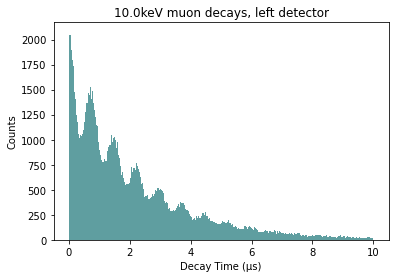

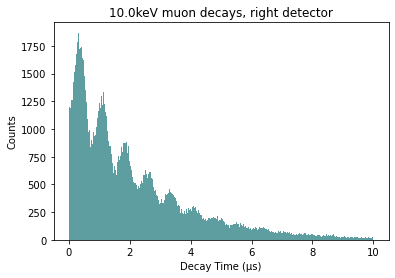

In [43]:
#defines bin count for calculating asymmetry and for plotting histograms of counts
bin_count = 500
hist_bin_count = 500

midtime_array = 0.5 * (np.linspace(0, 10, bin_count+1)[:-1] + np.linspace(0, 10, bin_count+1)[1:])

plt.hist(data[data[:, energy_dict[10]]==1,energy_dict[10]-1], hist_bin_count, color = 'cadetblue')
plt.xlabel('Decay Time (µs)')
plt.ylabel('Counts')
plt.title('10.0keV muon decays, left detector')
plt.show()
plt.hist(data[data[:, energy_dict[10]]==2,energy_dict[10]-1], hist_bin_count, color = 'cadetblue')
plt.xlabel('Decay Time (µs)')
plt.ylabel('Counts')
plt.title('10.0keV muon decays, right detector')
plt.show()

The following function takes column input, counts the left and right detections and sorts these into bins of each time midpoint. It calculates the asymmetry and the asymmetry uncertainty at each time using the formulae seen above and returns the results. The 10keV energy asymmetry is plotted against time.

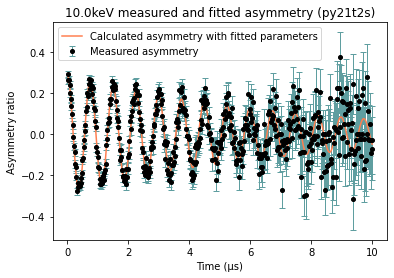

In [44]:
def asymmetry_finder(col):
    l = data[:, col]==1
    r = data[:, col]==2
    left_array = data[l,col-1]
    right_array = data[r,col-1]

    left_counts, times = np.histogram(left_array, bins=bin_count, range=(0, 10))
    right_counts = np.histogram(right_array, bins=bin_count, range=(0,10))[0]
    asymmetry_array = (left_counts - right_counts)/(left_counts + right_counts)
    asymmetry_uncertainty = 2 * np.sqrt((1/((left_counts+right_counts)**4))*(((left_counts**2) * right_counts)+((right_counts**2) * left_counts)))

    return asymmetry_array, asymmetry_uncertainty



#ensures that a 10keV energy exists otherwise plotting would give an error
if 10 in energy_dict:
    plt.errorbar(midtime_array, asymmetry_finder(energy_dict[10])[0], yerr=asymmetry_finder(energy_dict[10])[1], markersize=4, label='Measured asymmetry',ecolor='cadetblue', color='k', markerfacecolor='k', marker='o', capsize=3, linewidth=1, linestyle='')
    plt.plot(midtime_array, asymmetry_damped(midtime_array, B_dict[10][0], beta_dict[10][0], tau_dict[10][0]), color='coral', label='Calculated asymmetry with fitted parameters')
    plt.legend()
    plt.xlabel('Time (µs)')
    plt.ylabel('Asymmetry ratio')
    plt.title('10.0keV measured and fitted asymmetry (py21t2s)')
    plt.show()

To obtain values for the magnetic field within the implantation material, we must use numerical methods on this data. 

$$A_0(t) = \frac{sin(\beta) cos(\gamma B t)}{3 \beta} e^{-\frac{t}{\tau_{damp}}}$$

We want to first obtain initial guesses for $B$, $\beta$ and $\tau$ as this will make the program more efficient and ensure that when we later employ more sophisticated methods, we obtain an accurate result. The function finds the times at which asymmetry goes from positive to negative and vice-versa, and from which it can estimate $B$. It then uses fsolve to find an estimate for $\beta$ numerically. 

In [45]:
def initial_guesses(asymmetry_array):
    '''
    Returns initial guesses for B, beta and tau for an input asymmetry array. 
    '''

    intercept_indices = []
    for i in range(len(asymmetry_array)):
        if np.sign(asymmetry_array[i]) != np.sign(asymmetry_array[i+1]) and np.sign(asymmetry_array[i]) != np.sign(asymmetry_array[i+2]) and np.sign(asymmetry_array[i]) != np.sign(asymmetry_array[i+3]):
            intercept_indices += [i]
        elif len(intercept_indices)>=6:
            break
        else:
            continue


    #makes function for beta guess and then creates both variables for p0
    def beta_guesser(beta):
        return (np.sin(beta)/(3*beta)) - asymmetry_array[0]


    beta_estimate = fsolve(beta_guesser, 1)[0]
    #for robustness, this prevents any estimates from being outside the expected range
    if beta_estimate > 1.5:
        beta_estimate = 1.49
    elif beta_estimate < 0.5:
        beta_estimate = 0.51

    B_estimate = 6.2832/(851.616*((midtime_array[intercept_indices[4]]-midtime_array[intercept_indices[0]])/2))
    if B_estimate > 0.03:
        B_estimate = 0.029
    elif B_estimate < 0:
        B_estimate = 0.01

    return(B_estimate, beta_estimate, 0.000004)

In order to use numerical methods to find accurate estimates of $B$, $\beta$ and $\tau$, first a damped asymmetry function must be defined.

In [28]:
def asymmetry_damped(t, B, beta, tau):
    """
    Function for damped asymmetry calculation. Returns asymmetry for input time, B, beta and tau.
    The gyromagnetic ratio given 1 million times smaller to account for time unit of mircroseconds.
    """
    return (np.cos(851.616*B*t)*np.sin(beta)*np.exp(-(t*0.000001)/tau))/(3*beta)

The code below goes through the data for each energy in the file and uses non-linear least squares regression, along with our initial guesses, to accurately measure the values of interest, which are then stored in arrays and dictionaries which assign each energy level its corresponding value.

In [35]:
energy_array = np.array([])
B_array = np.array([])
B_unc = np.array([])

B_dict = {}
beta_dict = {}
tau_dict = {}
beta_array = np.array([])

for i in energy_dict:
    #calculates the accurate estimations for B, beta and tau for each energy in the energy dictionary
    #appends each value to corresponding dictionary/array
    popt,pcov = curve_fit(asymmetry_damped, midtime_array, asymmetry_finder(energy_dict[i])[0], sigma=asymmetry_finder(energy_dict[i])[1], absolute_sigma = True, p0=(initial_guesses(asymmetry_finder(energy_dict[i])[0])), bounds=([0,0.5,0.000002],[0.03,1.5,0.000008]))

    B_dict[i] = [popt[0], np.sqrt(np.diag(pcov))[0]]
    beta_dict[i] = [popt[1], np.sqrt(np.diag(pcov))[1]]
    tau_dict[i] = [popt[2], np.sqrt(np.diag(pcov))[2]]
    beta_array = np.append(beta_array, [popt[1], np.sqrt(np.diag(pcov))[1]])
        
    energy_array = np.append(energy_array, i)
    B_array = np.append(B_array, popt[0])
    B_unc = np.append(B_unc, np.sqrt(np.diag(pcov))[0])
        
        
#makes array 2 dimensional so indexing would give value and its uncertainty    
beta_array = beta_array.reshape(-1, 2)

The dataset includes multiple energies, so below is a plot showing how the magnetic field $B$ varies with implantation energy. The magnetic field $B$ should have a quadratic dependence on the energy, so the extracted values of $B$ are fit to a function of the form:

 $$|B|(E)=aE^2+bE+c$$ 
 
where $a$,$b$,$c$ are constants. Similar, non-linear least squares numerical methods are used to find these constants. This quadratic fit is overlayed on the plot.

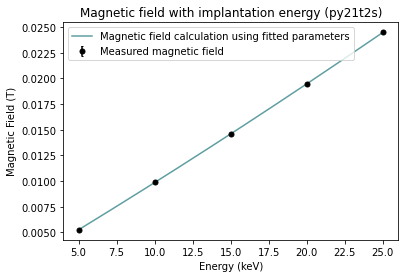

In [37]:
def energy_B_relation(E, a, b, c):
    '''
    Returns value of B for input values of E, a, b and c where abc are the quadratic coefficients.
    '''
    return (a*(E**2)) + (b*E) + c

#finds accurate estimation for values (and uncertainties) of a, b and c 
popt_abc, pcov_abc = curve_fit(energy_B_relation, energy_array, B_array, sigma=B_unc, absolute_sigma=True)
    
#plots measured B vs E against the fitted curve using estimated quadratic coefficients
plt.title('Magnetic field with implantation energy (py21t2s)')
plt.errorbar(energy_array, B_array, yerr=B_unc, capsize=1, markerfacecolor='k', color='k', linestyle='', marker='o', markersize=5, label='Measured magnetic field')
plt.plot(np.linspace(energy_array[0], energy_array[len(energy_array)-1], 1000), energy_B_relation(np.linspace(energy_array[0], energy_array[len(energy_array)-1], 1000), popt_abc[0], popt_abc[1], popt_abc[2]), color = 'cadetblue',label='Magnetic field calculation using fitted parameters')
plt.legend()    
plt.xlabel('Energy (keV)')
plt.ylabel('Magnetic Field (T)')
plt.show()

Finally, the 10keV energy results are stored in a dictionary.

In [36]:
results={"10keV_B":B_dict[10][0], #this would be the magnetic field for 10keV data (T)
         "10keV_B_error":B_dict[10][1], # the error in the magnetic field (T)
         "beta": np.mean(beta_array[:,0]), #Detector angle in radians
         "beta_error": np.std(beta_array, ddof=1) / np.sqrt(len(beta_array)), #uncertainity in detector angle (rad)
         "10keV_tau_damp": tau_dict[10][0], #Damping time for 10keV (s)
         "10keV_tau_damp_error": tau_dict[10][1], #and error (s)
         "B(Energy)_coeffs":(popt_abc[0],popt_abc[1],popt_abc[2]), #tuple of a,b,c for quadratic,linear and constant terms
         #for fitting B dependence on energy
         #(T/keV^2,T/keV,T)
         "B(Energy)_coeffs_errors":(np.sqrt(np.diag(pcov_abc))[0], np.sqrt(np.diag(pcov_abc))[1], np.sqrt(np.diag(pcov_abc))[2]), # Errors in above in same order.
        }
        
print(results)

{'10keV_B': 0.009870809493573792, '10keV_B_error': 6.3384245616006325e-06, 'beta': 0.932858517385861, 'beta_error': 0.20963263847993818, '10keV_tau_damp': 7.322897610251594e-06, '10keV_tau_damp_error': 4.0806358131858856e-07, 'B(Energy)_coeffs': (2.730337247927482e-06, 0.0008794276337570786, 0.0007945694010355345), 'B(Energy)_coeffs_errors': (6.973354437510916e-08, 2.1360644814213303e-06, 1.402887071426021e-05)}
